In [1]:
from jira import JIRA
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle
from dateutil.relativedelta import relativedelta

In [2]:
jira = JIRA(
    server='https://spaceneobank.atlassian.net',
    basic_auth=('ilya.b@payme.uz', 'ATATT3xFfGF0J2JFlWGLuBlzlK0r-mSzTLsnJdodqGcC8Cf-yII0Ed6EK8uGoA0hT0Q4Dj8kXdl__1ckXUW3bjFoKueb7fBffhX1YLz0VMVGLARwCC1mRHmj30WCLp7PM1lhRDxGjEFLpe72V9GN_0lGJCqATL_h6aW3df3indxmTbsT0uol5oA=0C746728')
)

In [3]:
today = date.today()
prev_month_name = (today - relativedelta(months=1)).strftime("%B %Y")
cur_month_name = today.strftime("%B %Y")

fields = "summary,status,priority,reporter,created,customfield_13373,customfield_13374,customfield_11656"

issues = jira.search_issues(
    "project = DQ ORDER BY created DESC",
    maxResults=50,
    fields=fields
)

In [4]:
# создание датафрейма
data = []
for issue in issues:
    data.append({
        'Key': issue.key,
        'Created': issue.fields.created,
        'Status': issue.fields.status.name,
        'Summary': issue.fields.status.name,
        'Priority': issue.fields.priority.name,
        'Reporter': issue.fields.reporter.displayName,
        'Improvement Requested': getattr(issue.fields, 'customfield_13373', None),
        'Summary': issue.fields.summary,
        'Improvement link': getattr(issue.fields, 'customfield_13374', None),
        'Error layer': getattr(issue.fields, 'customfield_11656', None),
    })
df = pd.DataFrame(data)
df['Created'] = pd.to_datetime(df['Created']).dt.date
cutoff_date = date.today() - timedelta(days=30)  #чтобы смотреть за последний месяц
#df = df[df["Created"] >= cutoff_date] # убери поле, если хоче посмотреть за все время, а не только за последний месяц
df['Improvement Requested'] = df['Improvement Requested'].apply(
    lambda x: True if x != None else False)
df['Improvement link'] = df['Improvement link'].apply(
    lambda x: str(x).split('|', 1)[1][:-1] if x != None else None)

# Выгрузить данные в excel

In [5]:
df.to_excel(f"выгрузка из JIRA ({today}).xlsx", index=False)

# Статистика за все время

In [6]:
target_statuses = ["Готово", "Handled by Assigned Team", "Hold", "Rejected"]

total = len(df)

summary = pd.DataFrame(
    {
        "Metric": [
            "Total number of incidents",
            "Incidents reviewed",   # Готово/Handled by Assigned Team/Hold/Rejected
            "Fixes requested",      # Improvement Requested == True
            "Incidents solved",     # Готово
        ],
        "Count": [
            total,
            df["Status"].isin(target_statuses).sum(),
            (df["Improvement Requested"] == True).sum(),
            (df["Status"] == "Готово").sum(),
        ],
    }
)

summary["Percent"] = (summary["Count"] / total * 100).round(2)
summary.loc[summary["Metric"] == "Total number of incidents", "Percent"] = 100.00

print(summary)

                      Metric  Count  Percent
0  Total number of incidents     49   100.00
1         Incidents reviewed     48    97.96
2            Fixes requested     25    51.02
3           Incidents solved     20    40.82


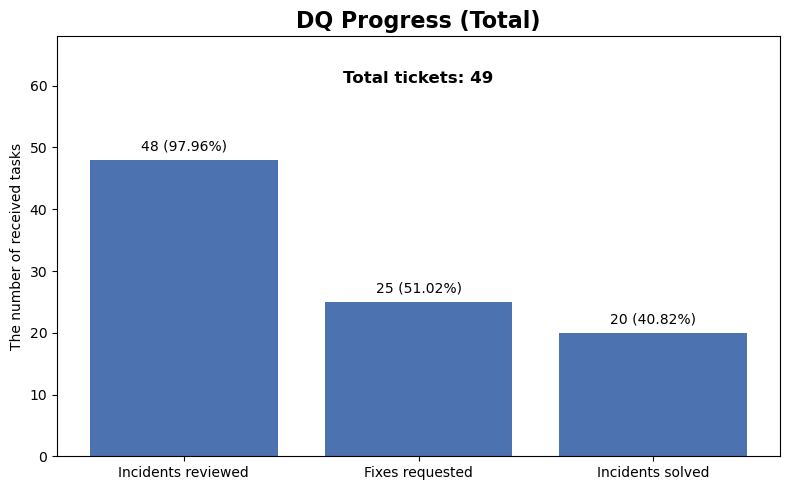

In [7]:
plot_df = summary[summary["Metric"] != "Total number of incidents"]

# Построение графика
fig_total, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(plot_df["Metric"], plot_df["Count"], color="#4C72B0")

# Подписи над столбиками (кол-во и %)
for bar, count, percent in zip(bars, plot_df["Count"], plot_df["Percent"]):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,  # чуть выше столбика
        f"{count} ({percent}%)",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Общее число заявок
ax.text(
    1,                      # центр над графиком
    max(plot_df["Count"]) + 12,
    f"Total tickets: {total}",
    ha="center",
    va="bottom",
    fontsize=12,
    fontweight="bold",
    color="black"
)

# Настройки осей
ax.set_ylabel("The number of received tasks")
ax.set_ylim(0, max(plot_df["Count"]) + 20)
ax.set_title("DQ Progress (Total)", fontsize=16, fontweight="bold")

plt.tight_layout()

# Ошибки по слоям за все время

In [8]:
summary_layer = pd.DataFrame(
    {
        "Error Level": [
            "DWH",
            "Source"
        ],
        "Count": [
            (df["Error layer"].astype(str) == "DWH").sum(),
            (df["Error layer"].astype(str) == "Source system").sum(),
        ],                                                            
    }
)
summary_layer["Percent"] = (summary_layer["Count"] / total * 100).round(2)
print(summary_layer)

  Error Level  Count  Percent
0         DWH     40    81.63
1      Source      9    18.37


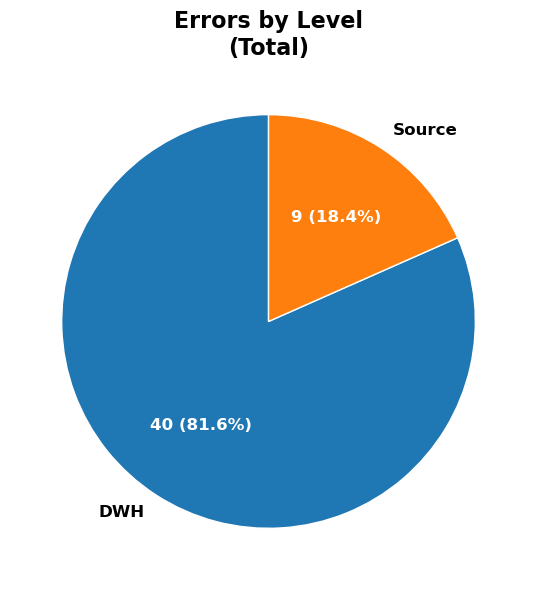

In [9]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f"{val} ({pct:.1f}%)"
    return my_autopct


fig_level, ax = plt.subplots(figsize=(6, 6))

wedges, texts, autotexts = ax.pie(
    summary_layer["Count"],
    labels=summary_layer["Error Level"],
    autopct=make_autopct(summary_layer["Count"]),
    startangle=90,
    wedgeprops={"edgecolor": "white"},
    # общий шрифт, но без цвета — цвет зададим отдельно
    textprops={"fontweight": "bold", "fontsize": 12},
    pctdistance=0.6,    # подписи с числами ближе к центру
    labeldistance=1.1,  # названия категорий чуть наружу
)

# Названия категорий – чёрные (вне сектора)
for t in texts:
    t.set_color("black")

# Числа/проценты внутри сектора – белые
for t in autotexts:
    t.set_color("white")

ax.set_title("Errors by Level\n(Total)", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

# Поступивших/Рассмотренных/Решенных задач прошлый месяц

In [10]:
jql = 'project = DQ AND created >= startOfMonth(-1) AND created < startOfMonth()'
prev_res_created = jira.search_issues(jql, maxResults=0, fields="none")
print("Поступило задач за прошлый месяц:", prev_res_created.total)

jql = 'project = DQ and status CHANGED TO ("Done","Handled by Assigned Team","Hold") DURING (startOfMonth(-1), startOfMonth()) AND created >= startOfMonth(-1) AND created < startOfMonth()'
prev_res_reviewed = jira.search_issues(jql, maxResults=0, fields="none")
prev_count_done_this_month = prev_res_reviewed.total
print("Рассмотрели запросов за прошлый месяц:", prev_count_done_this_month)

jql = 'project = DQ and status CHANGED TO "Done" DURING (startOfMonth(-1), startOfMonth())'
prev_res_done = jira.search_issues(jql, maxResults=0, fields="none")
prev_count_done_this_month = prev_res_done.total
print("Переведено в 'Готово' за прошлый месяц:", prev_count_done_this_month)

Поступило задач за прошлый месяц: 22
Рассмотрели запросов за прошлый месяц: 22
Переведено в 'Готово' за прошлый месяц: 5


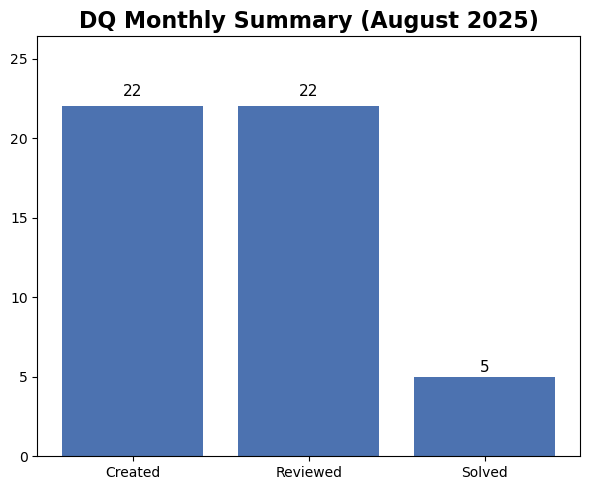

In [11]:
prev_count_created =  prev_res_created.total   # из jql на created
prev_count_reviewed = prev_res_reviewed.total  # из jql на Done/Handled/Hold
prev_count_done = prev_res_done.total          # из jql на Done

df_metrics = pd.DataFrame({
    "Metric": ["Created", "Reviewed", "Solved"],
    "Count": [prev_count_created, prev_count_reviewed, prev_count_done]
})

fig_prev_month, ax = plt.subplots(figsize=(6,5))
bars = ax.bar(df_metrics["Metric"], df_metrics["Count"], color="#4C72B0")
max_count = df_metrics["Count"].max()
ax.set_ylim(0, max_count * 1.2)

for bar, count in zip(bars, df_metrics["Count"]):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + (count * 0.02 if count > 0 else 1),
        str(count),
        ha="center", va="bottom", fontsize=11
    )

ax.set_title(f"DQ Monthly Summary ({prev_month_name})", fontsize=16, fontweight="bold")
#ax.set_ylabel("The number of tasks")

plt.tight_layout()
plt.show()

# Поступивших/Рассмотренных/Решенных задач прошлый месяц

In [12]:
jql = 'project = DQ AND created >= startOfMonth()'
cur_res_created = jira.search_issues(jql, maxResults=0, fields="none")
print("Поступило задач за текущий месяц:", cur_res_created.total)

jql = 'project = DQ and status CHANGED TO ("Done","Handled by Assigned Team","Hold") DURING (startOfMonth(), now()) AND created >= startOfMonth()'
cur_res_reviewed = jira.search_issues(jql, maxResults=0, fields="none")
cur_count_done_this_month = cur_res_reviewed.total
print("Рассмотрели запросов за текущий месяц:", cur_count_done_this_month)

jql = 'project = DQ and status CHANGED TO "Done" DURING (startOfMonth(), now())'
cur_res_done = jira.search_issues(jql, maxResults=0, fields="none")
cur_count_done_this_month = cur_res_done.total
print("Переведено в 'Готово' за текущий месяц:", cur_count_done_this_month)

Поступило задач за текущий месяц: 2
Рассмотрели запросов за текущий месяц: 1
Переведено в 'Готово' за текущий месяц: 5


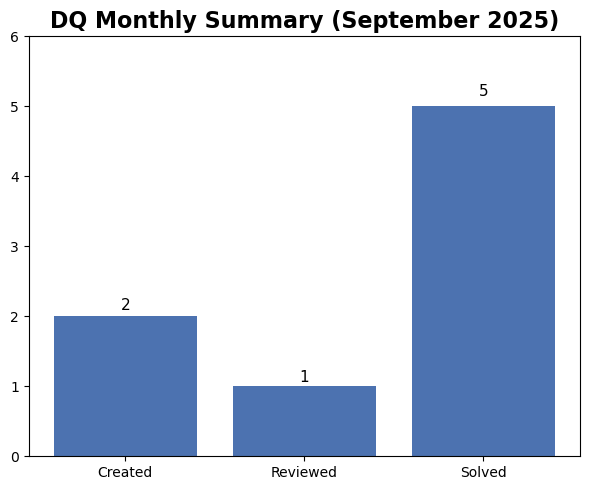

In [13]:
cur_count_created =  cur_res_created.total   # из jql на created
cur_count_reviewed = cur_res_reviewed.total  # из jql на Done/Handled/Hold
cur_count_done = cur_res_done.total          # из jql на Done

df_metrics = pd.DataFrame({
    "Metric": ["Created", "Reviewed", "Solved"],
    "Count": [cur_count_created, cur_count_reviewed, cur_count_done]
})

fig_cur_month, ax = plt.subplots(figsize=(6,5))
bars = ax.bar(df_metrics["Metric"], df_metrics["Count"], color="#4C72B0")
max_count = df_metrics["Count"].max()
ax.set_ylim(0, max_count * 1.2)

for bar, count in zip(bars, df_metrics["Count"]):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + (count * 0.02 if count > 0 else 1),
        str(count),
        ha="center", va="bottom", fontsize=11
    )

ax.set_title(f"DQ Monthly Summary ({cur_month_name})", fontsize=16, fontweight="bold")
#ax.set_ylabel("The number of tasks")

plt.tight_layout()
plt.show()

# Когорта по месяцам

In [31]:
month_name_3 = (today - relativedelta(months=3)).strftime("%B %Y")
month_name_2 = (today - relativedelta(months=2)).strftime("%B %Y")
month_name_1 = (today - relativedelta(months=1)).strftime("%B %Y")
month_name_0 = today.strftime("%B %Y")

months = {
    "month_name_3": (today - relativedelta(months=3)).strftime("%B %Y"),
    "month_name_2": (today - relativedelta(months=2)).strftime("%B %Y"),
    "month_name_1": (today - relativedelta(months=1)).strftime("%B %Y"),
    "month_name_0": today.strftime("%B %Y")
}

results = dict()
total_created = 0
total_left = 0
total_critical_left = jira.search_issues(
    'project = DQ AND priority = Highest AND status not in ("Done", "Rejected")',
    maxResults=1000, fields="summary,priority,status"
).total

created_counts = []  # <— добавил, чтобы потом собрать серию "Created"

for month in months:
    results[month] = []
    month_num = -int(str(month)[-1])
    next_month_num = -int(str(month)[-1]) + 1

    jql = (
        f'project = DQ AND created >= startOfMonth({month_num}) '
        f'AND created < startOfMonth({next_month_num})'
    )
    res_created = jira.search_issues(jql, maxResults=0, fields="none")

    print(f"Поступило задач за {months[month]}:", res_created.total)
    total_created += res_created.total
    created_counts.append(res_created.total)  # <— сохраняем помесячно

    for month1 in months:
        # разрешаем засчитывать только месяцы закрытия, не «позже» исходного
        if int(str(month)[-1]) < int(str(month1)[-1]):
            continue
        month_num1 = -int(str(month1)[-1])
        next_month_num1 = -int(str(month1)[-1]) + 1
        jql = (
            f'project = DQ and status CHANGED TO "Done" '
            f'DURING (startOfMonth({month_num1}), startOfMonth({next_month_num1})) '
            f'AND created >= startOfMonth({month_num}) AND created < startOfMonth({next_month_num})'
        )
        cur_res_done = jira.search_issues(jql, maxResults=0, fields="none")
        results[month].append(cur_res_done.total)
        print(f"Переведено в 'Готово' задач из {months[month]} в {months[month1]}:", cur_res_done.total)

    print(f"Всего решено из {months[month]}: ", sum(results[month]))
    print(f"Осталось решить из {months[month]}: ", res_created.total - sum(results[month]))
    total_left += res_created.total - sum(results[month])
    print('')

print('Всего поступило: ', total_created)
print('Всего осталось решить: ', total_left)
print('Нерешенных критических: ', total_critical_left)

Поступило задач за June 2025: 1
Переведено в 'Готово' задач из June 2025 в June 2025: 0
Переведено в 'Готово' задач из June 2025 в July 2025: 0
Переведено в 'Готово' задач из June 2025 в August 2025: 0
Переведено в 'Готово' задач из June 2025 в September 2025: 0
Всего решено из June 2025:  0
Осталось решить из June 2025:  1

Поступило задач за July 2025: 23
Переведено в 'Готово' задач из July 2025 в July 2025: 11
Переведено в 'Готово' задач из July 2025 в August 2025: 2
Переведено в 'Готово' задач из July 2025 в September 2025: 2
Всего решено из July 2025:  15
Осталось решить из July 2025:  8

Поступило задач за August 2025: 22
Переведено в 'Готово' задач из August 2025 в August 2025: 3
Переведено в 'Готово' задач из August 2025 в September 2025: 2
Всего решено из August 2025:  5
Осталось решить из August 2025:  17

Поступило задач за September 2025: 2
Переведено в 'Готово' задач из September 2025 в September 2025: 1
Всего решено из September 2025:  1
Осталось решить из September 2025:

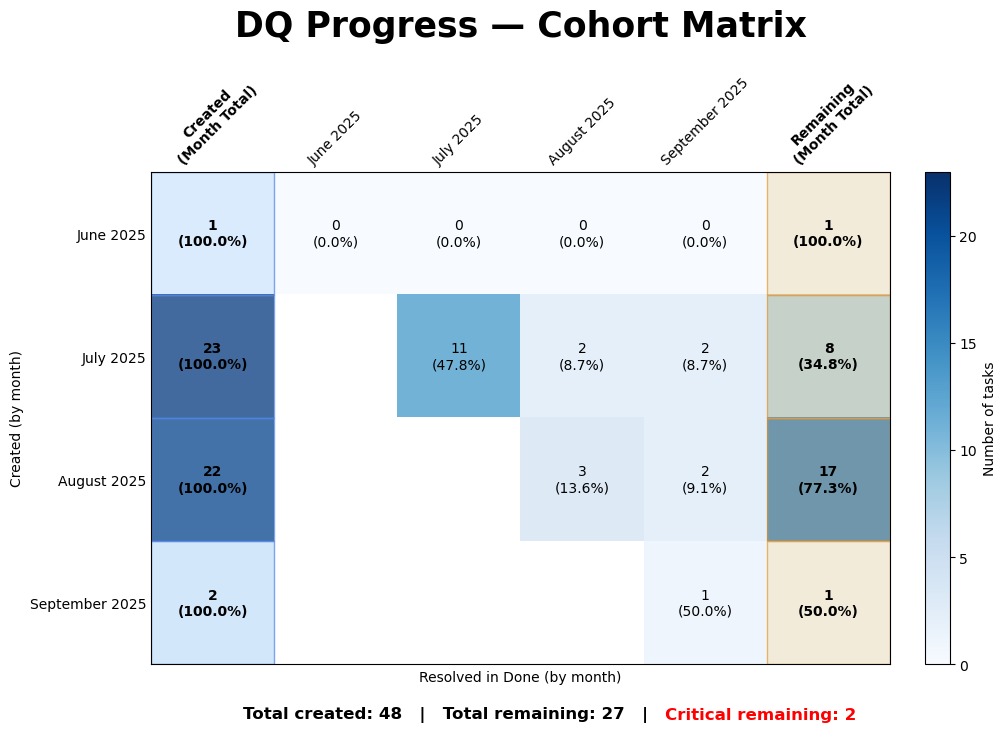

In [36]:
order_keys = ["month_name_3", "month_name_2", "month_name_1", "month_name_0"]
labels = [months[k] for k in order_keys]
n = len(order_keys)

# Матрица переходов (создано-месяц -> закрыто-месяц)
M = pd.DataFrame(np.nan, index=labels, columns=labels, dtype=float)

for i, k_row in enumerate(order_keys):
    row_vals = list(results.get(k_row, []))
    want = n - i
    use = min(want, len(row_vals))

    for off in range(use):
        j = i + off
        M.iat[i, j] = row_vals[off]

    # справа от последних фактических значений кладём 0 (служебные нули)
    for j in range(i + use, n):
        M.iat[i, j] = 0.0


created = pd.Series(created_counts, index=labels, name="Created\n(Month Total)").astype(int)

resolved_in_grid = M.sum(axis=1).astype(int)
remaining = (created - resolved_in_grid).clip(lower=0)
remaining.name = "Remaining\n(Month Total)"

M_ext = pd.concat([created, M, remaining], axis=1)


order_keys = ["month_name_3", "month_name_2", "month_name_1", "month_name_0"]
labels = [months[k] for k in order_keys]
n = len(order_keys)

M = pd.DataFrame(np.nan, index=labels, columns=labels, dtype=float)

for i, k_row in enumerate(order_keys):
    row_vals = list(results.get(k_row, []))
    want = n - i
    use = min(want, len(row_vals))

    for off in range(use):
        j = i + off
        M.iat[i, j] = row_vals[off]

    for j in range(i + use, n):
        M.iat[i, j] = 0.0

created = pd.Series(created_counts, index=labels, name="Created\n(Month Total)").astype(int)

resolved_in_grid = M.sum(axis=1).astype(int)
remaining = (created - resolved_in_grid).clip(lower=0)
remaining.name = "Remaining\n(Month Total)"

M_ext = pd.concat([created, M, remaining], axis=1)

# --- ГРАФИК --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(1.3*len(M_ext.columns)+3, 1.3*len(M_ext.index)+2))

cmap = plt.get_cmap("Blues").copy()
cmap.set_bad(color="white")
im = ax.imshow(M_ext.values, cmap=cmap)

ax.set_xticks(range(M_ext.shape[1]))
ax.set_yticks(range(M_ext.shape[0]))
ax.set_xticklabels(M_ext.columns, rotation=45, ha='center')
ax.set_yticklabels(M_ext.index)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, left=False, right=False, length=0)

for lbl in ax.get_xticklabels():
    if lbl.get_text() in ["Created\n(Month Total)", "Remaining\n(Month Total)"]:
        lbl.set_fontweight("bold")

n_rows, n_cols = M_ext.shape
for i in range(n_rows):
    denom = created.iloc[i]
    for j, col_name in enumerate(M_ext.columns):
        # пропускаем левый «пустой» треугольник внутри сетки M
        if 1 <= j <= n and (j - 1) < i:
            continue
        val = M_ext.iat[i, j]
        if pd.isna(val):
            continue
        count = int(val)
        pct = (count / denom * 100) if denom > 0 else 0.0
        fw = "bold" if col_name in ["Created\n(Month Total)", "Remaining\n(Month Total)"] else "normal"
        ax.text(j, i, f"{count}\n({pct:.1f}%)",
                ha='center', va='center', fontsize=10, fontweight=fw, color="black")

left_col = 0
right_col = n_cols - 1
for i in range(n_rows):
    ax.add_patch(Rectangle((left_col-0.5, i-0.5), 1, 1,
                           facecolor=(0.70, 0.85, 1.00, 0.35),
                           edgecolor=(0.30, 0.50, 0.90, 0.70), linewidth=1.0))
    ax.add_patch(Rectangle((right_col-0.5, i-0.5), 1, 1,
                           facecolor=(1.00, 0.85, 0.60, 0.35),
                           edgecolor=(0.90, 0.60, 0.20, 0.70), linewidth=1.0))

ax.set_xlabel("Resolved in Done (by month)")
ax.set_ylabel("Created (by month)")
ax.set_title("DQ Progress — Cohort Matrix", fontsize=25, fontweight="bold", pad=25)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Number of tasks")

# было дважды; оставим авто-лейаут
plt.tight_layout(rect=[0, 0.05, 1, 1])

left_text = f"Total created: {total_created}   |   Total remaining: {total_left}   |   "
right_text = f"Critical remaining: {total_critical_left}"
fig.subplots_adjust(bottom=0.1)
x_center = 0.675
fig.text(x_center, 0.02, left_text, ha='right', va='bottom',
         fontsize=12, fontweight='bold', color='black')
fig.text(x_center, 0.02, right_text, ha='left', va='bottom',
         fontsize=12, fontweight='bold', color='red')

plt.show()

# Когорта по критическим

In [16]:
month_name_3 = (today - relativedelta(months=3)).strftime("%B %Y")
month_name_2 = (today - relativedelta(months=2)).strftime("%B %Y")
month_name_1 = (today - relativedelta(months=1)).strftime("%B %Y")
month_name_0 = today.strftime("%B %Y")


months = {
  "month_name_3": (today - relativedelta(months=3)).strftime("%B %Y"),
  "month_name_2": (today - relativedelta(months=2)).strftime("%B %Y"),
  "month_name_1": (today - relativedelta(months=1)).strftime("%B %Y"),
  "month_name_0": today.strftime("%B %Y")  
}


results = dict()
total_critical_created = 0
total_critical_left = 0

for month in months:
    results[month] = []
    month_num = -int(str(month)[-1])
    next_month_num = -int(str(month)[-1])+1
    jql = f'project = DQ AND priority = Highest AND created >= startOfMonth({month_num}) AND created < startOfMonth({next_month_num})'
    res_created = jira.search_issues(jql, maxResults=0, fields="none")
    print(f"Поступило задач за {months[month]}:", res_created.total)
    total_critical_created+=res_created.total
    for month1 in months:
        if int(str(month)[-1]) < int(str(month1)[-1]):
            continue
        else:
            month_num1 = -int(str(month1)[-1])
            next_month_num1 = -int(str(month1)[-1])+1
            jql = f'project = DQ AND priority = Highest and status CHANGED TO "Done" DURING (startOfMonth({month_num1}), startOfMonth({next_month_num1})) AND created >= startOfMonth({month_num}) AND created < startOfMonth({next_month_num})'
            cur_res_done = jira.search_issues(jql, maxResults=0, fields="none")
            results[month].append(cur_res_done.total)
            print(f"Переведено в 'Готово' задач из {months[month]} в {months[month1]}:", cur_res_done.total)   
    print(f"Всего решено из {months[month]}: ", sum(results[month]))
    print(f"Осталось решить из {months[month]}: ", res_created.total-sum(results[month]))
    total_critical_left+=res_created.total-sum(results[month])
    print('')
#print(results)

print('Всего поступило: ',total_critical_created)
print('Всего осталось решить: ',total_critical_left)

Поступило задач за June 2025: 0
Переведено в 'Готово' задач из June 2025 в June 2025: 0
Переведено в 'Готово' задач из June 2025 в July 2025: 0
Переведено в 'Готово' задач из June 2025 в August 2025: 0
Переведено в 'Готово' задач из June 2025 в September 2025: 0
Всего решено из June 2025:  0
Осталось решить из June 2025:  0

Поступило задач за July 2025: 1
Переведено в 'Готово' задач из July 2025 в July 2025: 0
Переведено в 'Готово' задач из July 2025 в August 2025: 0
Переведено в 'Готово' задач из July 2025 в September 2025: 0
Всего решено из July 2025:  0
Осталось решить из July 2025:  1

Поступило задач за August 2025: 3
Переведено в 'Готово' задач из August 2025 в August 2025: 1
Переведено в 'Готово' задач из August 2025 в September 2025: 1
Всего решено из August 2025:  2
Осталось решить из August 2025:  1

Поступило задач за September 2025: 1
Переведено в 'Готово' задач из September 2025 в September 2025: 1
Всего решено из September 2025:  1
Осталось решить из September 2025:  0



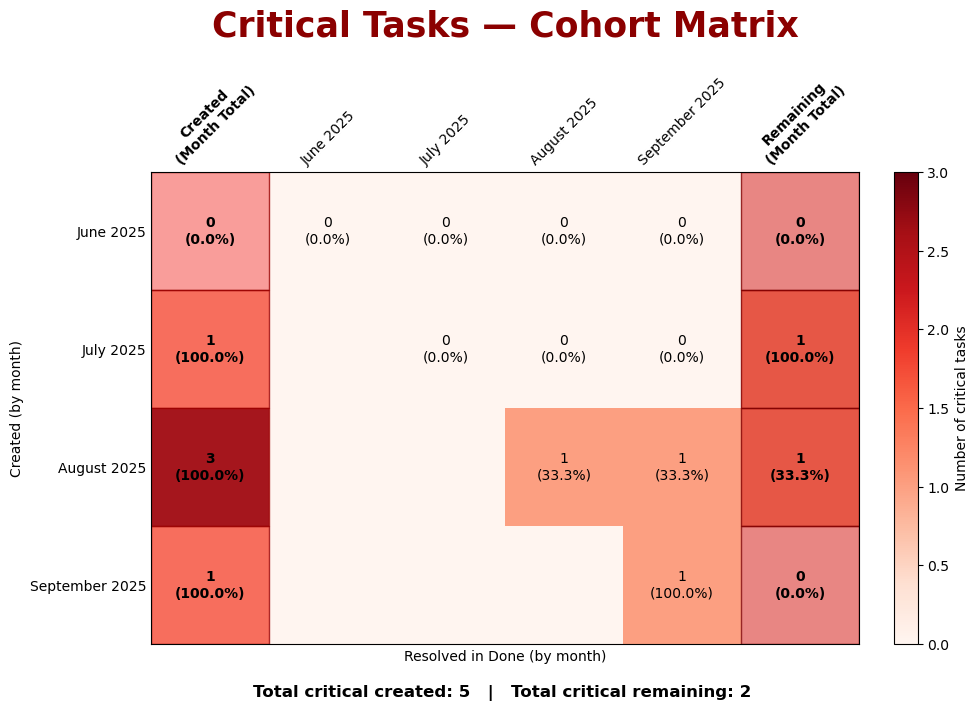

In [22]:
order_keys = ["month_name_3", "month_name_2", "month_name_1", "month_name_0"]
labels = [months[k] for k in order_keys]
n = len(order_keys)

M_crit = pd.DataFrame(np.nan, index=labels, columns=labels)
for i, k_row in enumerate(order_keys):

    off_created = -int(k_row[-1])
    row_vals = []
    for j, k_col in enumerate(order_keys):
        if j < i:
            continue  
        off_resolved = -int(k_col[-1])
        jql_done_crit = (
            'project = DQ '
            f'AND priority = Highest '
            f'AND created >= startOfMonth({off_created}) AND created < startOfMonth({off_created+1}) '
            f'AND status CHANGED TO "Done" DURING (startOfMonth({off_resolved}), startOfMonth({off_resolved+1}))'
        )
        res_dc = jira.search_issues(jql_done_crit, maxResults=0, fields="none")
        row_vals.append(res_dc.total)
    # разложим row_vals по диагонали и вправо
    for off, val in enumerate(row_vals):
        M_crit.iat[i, i+off] = val
    # добьём нулями допустимую правую часть, если нужно
    for j in range(i + len(row_vals), n):
        M_crit.iat[i, j] = 0

M_crit = M_crit.fillna(0).astype(int)

created_crit_counts = []
for k in order_keys:
    off = -int(k[-1])
    jql_created_crit = (
        'project = DQ '
        'AND priority = Highest '
        f'AND created >= startOfMonth({off}) AND created < startOfMonth({off+1})'
    )
    res_cc = jira.search_issues(jql_created_crit, maxResults=0, fields="none")
    created_crit_counts.append(res_cc.total)

created_crit = pd.Series(created_crit_counts, index=labels, name="Created\n(Month Total)").astype(int)
resolved_crit_in_grid = M_crit.sum(axis=1).astype(int)
remaining_crit = (created_crit - resolved_crit_in_grid).clip(lower=0)
remaining_crit.name = "Remaining\n(Month Total)"


M_ext_crit = pd.concat([created_crit, M_crit, remaining_crit], axis=1)


fig_crit, ax = plt.subplots(figsize=(1.3*len(M_ext_crit.columns)+3, 1.3*len(M_ext_crit.index)+2))

cmap_r = plt.get_cmap("Reds").copy()
cmap_r.set_bad(color="white")  
im = ax.imshow(M_ext_crit.values, cmap=cmap_r)

ax.set_xticks(range(M_ext_crit.shape[1]))
ax.set_yticks(range(M_ext_crit.shape[0]))
ax.set_xticklabels(M_ext_crit.columns, rotation=45, ha='center')
ax.set_yticklabels(M_ext_crit.index)


ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False,
               left=False, right=False, length=0)

for lbl in ax.get_xticklabels():
    if lbl.get_text() in ["Created\n(Month Total)", "Remaining\n(Month Total)"]:
        lbl.set_fontweight("bold")

n_rows, n_cols = M_ext_crit.shape
for i in range(n_rows):
    denom = created_crit.iloc[i]
    for j, col_name in enumerate(M_ext_crit.columns):
        if 1 <= j <= n and (j - 1) < i:
            continue
        val = M_ext_crit.iat[i, j]
        if pd.isna(val):
            continue
        count = int(val)
        pct = (count / denom * 100) if denom > 0 else 0.0
        fw = "bold" if col_name in ["Created\n(Month Total)", "Remaining\n(Month Total)"] else "normal"
        ax.text(j, i, f"{count}\n({pct:.1f}%)",
                ha='center', va='center', fontsize=10, fontweight=fw, color="black")

left_col = 0
right_col = n_cols - 1
for i in range(n_rows):
    ax.add_patch(Rectangle((left_col-0.5, i-0.5), 1, 1,
                           facecolor=(0.95, 0.2, 0.2, 0.45),   
                           edgecolor=(0.6, 0.0, 0.0, 0.8), linewidth=1.0))
    ax.add_patch(Rectangle((right_col-0.5, i-0.5), 1, 1,
                           facecolor=(0.8, 0.0, 0.0, 0.45),   
                           edgecolor=(0.5, 0.0, 0.0, 0.8), linewidth=1.0))

ax.set_xlabel("Resolved in Done (by month)")
ax.set_ylabel("Created (by month)")
ax.set_title("Critical Tasks — Cohort Matrix",
             fontsize=25, fontweight="bold", pad=25, color="darkred")

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Number of critical tasks")

fig_crit.subplots_adjust(bottom=0.12)
footer_left = f"Total critical created: {total_critical_created}   |   Total critical remaining: {total_critical_left}"
fig_crit.text(0.55, 0.02, footer_left, ha='center', va='bottom',
         fontsize=12, fontweight='bold', color='black')
fig_crit.subplots_adjust(bottom=0.18)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# Создать PDF

In [37]:
with PdfPages(f"jira_report ({cur_month_name}).pdf") as pdf:
    #pdf.savefig(fig_prev_month, bbox_inches="tight")
    #pdf.savefig(fig_cur_month, bbox_inches="tight")
    pdf.savefig(fig, bbox_inches="tight")
    pdf.savefig(fig_crit, bbox_inches="tight")
    pdf.savefig(fig_total, bbox_inches="tight")
    pdf.savefig(fig_level, bbox_inches="tight")